# Demo - NeMo ASR Application 
Compare trained models on any audio file.

In this demo we compare the models created by the `WSJ__Domain_Specific_ASR` notebook:
- **Pre-trained**: Model trained on LibriSpeech and Mozilla Common Voice datasets `['am-pretrained-greedy-decoder']`.
- **Finetuned**: Pre-trained model fine-tuned on Wall Street Journal dataset `['am-finetuned-WSJ_train_speed-greedy-decoder']`.
- **Finetuned with LM**: Acoustic model fine-tuned on Wall Street Journal dataset with Languague Model trained on WSJ `['am-finetuned-WSJ_train_speed--lm-WSJ']`.

Additionally, we compare a model trained on multiple datasets to demonstrate the effect of training on more data.

### Models Performance on `wsj-eval-92`:
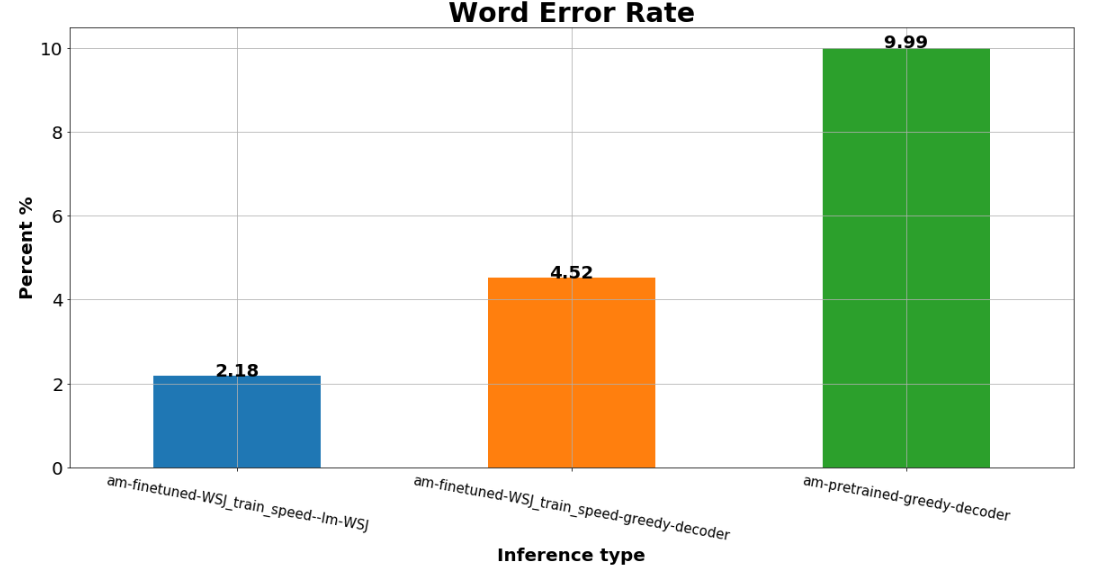

In [1]:
# required imports
%load_ext autoreload
%autoreload 2

import os
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io.wavfile as wave
import IPython.display as ipd
from IPython.core.display import display, HTML
from tools.misc import show_diff
from tools.System.config import cfg
from tools.NeMo.demo_inference import offline_inference
from nemo.collections.asr.helpers import word_error_rate

/opt/conda/lib/python3.6/site-packages/nemo/collections/asr/audio_preprocessing.py:48: UserWarning: Could not import torchaudio. Some features might not work.
  warnings.warn('Could not import torchaudio. Some features might not work.')


# 1. Select Audio file
First, select an audio file you wish to use to compare the models. We provide you with some WSJ audio examples, none of the models have *seen* these audio files before.

In [2]:
audio_file = 'audios/example1.wav' # bankers in hong kong expect sinopec to return for more syndicated loans as it develops china's petrochemical industry
truth = ["bankers in hong kong expect sinopec to return for more syndicated loans as it develops china's petrochemical industry"]

# other examples included in the container
#audio_file = 'audios/example2.wav' # however in light of the stakes already held by the various factions only about ten percent of generale de belgique's shares appeared to be available on the market
#truth = ["however in light of the stakes already held by the various factions only about ten percent of generale de belgique's shares appeared to be available on the market"]

#audio_file = 'audios/example3.wav' # abby joseph cohen a portfolio strategist at drexel burnham lambert says the less than ebullient reaction was entirely in keeping with the new mood on wall street
#truth = ["abby joseph cohen a portfolio strategist at drexel burnham lambert says the less than ebullient reaction was entirely in keeping with the new mood on wall street"]

print(truth)
ipd.Audio(audio_file) # audio playback

["bankers in hong kong expect sinopec to return for more syndicated loans as it develops china's petrochemical industry"]


### Or Record your own audio file
If you wish to test the models on a new audio you record, follow these steps:
1. Use this website to record your audio: https://voice-recorder-online.com/
2. Upload to this notebook's folder (drag and drop)
3. Set `audio_file_in` to the new recording added

**Note: Audio clips must be shorter than 15 seconds.**

In [3]:
# format audio clip (sampling rate)
def format_audio_rate(audio_clip_in, audio_clip_out):
    subprocess.check_output("sox -v 0.98 {0} -c 1 -r 16000 {1}".format(audio_clip_in, audio_clip_out), shell=True)
    sample_rate, signal = wave.read(audio_clip_out)
    print("Audio has been formatted and has sample rate: " + str(sample_rate))
    return audio_clip_out

In [4]:
#audio_file_in = 'audios/4k0c0301.wav' #update path to your recorded file
#audio_file = format_audio_rate(audio_file_in, "audios/audio_formatted.wav")
#truth = "saatchi officials said the management restructuring might accelerate its efforts to persuade clients to use the firm as a one stop shop for business services"
#ipd.Audio(audio_file) # audio playback

# 2. ASR Transcription
Now, we will run inference with each of the models on the selected audio.

Note:  This is not a recommended way to do inference in production workflows. If you are interested in production-level inference using NeMo ASR models, please sign-up to Jarvis early access program: https://developer.nvidia.com/nvidia-jarvis

## Pre-Trained Acoustic Model - Greedy Decoder

In [5]:
MODEL_YAML = os.path.join(cfg.NEMO.BASE_PATH, 'examples/asr/configs/quartznet15x5.yaml')
CHECKPOINT_ENCODER = '../models/quartznet15x5/JasperEncoder-STEP-247400.pt'
CHECKPOINT_DECODER = '../models/quartznet15x5/JasperDecoderForCTC-STEP-247400.pt'

In [6]:
pretrained, probs = offline_inference(MODEL_YAML, CHECKPOINT_ENCODER, CHECKPOINT_DECODER, audio_file)
pretrained

[NeMo I 2020-04-15 22:56:48 features:144] PADDING: 16
[NeMo I 2020-04-15 22:56:48 features:152] STFT using conv


['bakers in hong kong expect synopec to return fom more sindicated loans as it develops chinas petro chemical industry']

## Fine-Tuned Acoustic Model - Greedy Decoder

In [7]:
MODEL_YAML = os.path.join(cfg.NEMO.BASE_PATH, 'examples/asr/configs/quartznet15x5.yaml')
CHECKPOINT_ENCODER = '../models/wsj_finetuned/JasperEncoder-STEP-174000.pt'
CHECKPOINT_DECODER = '../models/wsj_finetuned/JasperDecoderForCTC-STEP-174000.pt'

In [8]:
finetuned, f_probs = offline_inference(MODEL_YAML, CHECKPOINT_ENCODER, CHECKPOINT_DECODER, audio_file)
finetuned

[NeMo I 2020-04-15 22:56:52 features:144] PADDING: 16
[NeMo I 2020-04-15 22:56:52 features:152] STFT using conv


["bankers in hong kong expect synnopec to return for more syndicated loans as it develops china's petro chemical industry"]

## Fine-Tuned Acoustic Model - Language Model

In [9]:
# model config
MODEL_YAML = os.path.join(cfg.NEMO.BASE_PATH, 'examples/asr/configs/quartznet15x5.yaml')
# acoustic model
CHECKPOINT_ENCODER = '../models/wsj_finetuned/JasperEncoder-STEP-174000.pt'
CHECKPOINT_DECODER = '../models/wsj_finetuned/JasperDecoderForCTC-STEP-174000.pt'
# language model
lm = '../models/lm/WSJ_lm.binary'

In [10]:
f_transcript, f_preds, finetuned_lm = offline_inference(MODEL_YAML, CHECKPOINT_ENCODER, CHECKPOINT_DECODER, audio_file, lm)
finetuned_lm

[NeMo I 2020-04-15 22:56:53 features:144] PADDING: 16
[NeMo I 2020-04-15 22:56:53 features:152] STFT using conv


"bankers in hong kong expect sinopec to return for more syndicated loans as it develops china's petro chemical industry"

# (Additional) Multi Dataset Model
This model is trained on ~6000 hours of data form various sources including: LibriSpeech, Common Voice (December 2019), Fisher, Switchboard, WSJ, Singapore NSC Part-1

In [11]:
MODEL_YAML = os.path.join(cfg.NEMO.BASE_PATH, 'examples/asr/configs/jasper10x5dr.yaml')
CHECKPOINT_ENCODER = '../models/multi_dataset_v2/JasperEncoder-STEP-400000.pt'
CHECKPOINT_DECODER = '../models/multi_dataset_v2/JasperDecoderForCTC-STEP-400000.pt'

In [12]:
multidataset, f_probs = offline_inference(MODEL_YAML, CHECKPOINT_ENCODER, CHECKPOINT_DECODER, audio_file)
multidataset

[NeMo I 2020-04-15 22:56:59 features:144] PADDING: 16
[NeMo I 2020-04-15 22:56:59 features:152] STFT using conv


["bankers in hong kong expects cynopex to return for more syndicated loans as it develops china's petrochemical industry"]

# 3. Comparing Results
Next, we compare the transcriptions of each model.

We show the text comparison marking the differences on:
- **green** = insert
- **red** = delete
- **blue** = replace

## Pre-trained Model vs. Ground Truth

In [13]:
wer = word_error_rate(hypotheses=pretrained, references=truth) 
print("Pretrained Model- WER: %.2f %% \n" % (wer*100))
print("Truth: %s " % truth[0])
print("Model: %s\n" % pretrained[0])
display(HTML(show_diff(truth[0], pretrained[0])))

Pretrained Model- WER: 38.89 % 

Truth: bankers in hong kong expect sinopec to return for more syndicated loans as it develops china's petrochemical industry 
Model: bakers in hong kong expect synopec to return fom more sindicated loans as it develops chinas petro chemical industry



## Fine-tuned Model vs. Ground Truth

In [14]:
wer = word_error_rate(hypotheses=finetuned, references=truth) 
print("Finetuned-Greedy Model WER: %.2f %% \n" % (wer*100))

print("Truth: %s" % truth[0])
print("Model: %s\n" % finetuned[0])
display(HTML(show_diff(truth[0], finetuned[0])))

Finetuned-Greedy Model WER: 16.67 % 

Truth: bankers in hong kong expect sinopec to return for more syndicated loans as it develops china's petrochemical industry
Model: bankers in hong kong expect synnopec to return for more syndicated loans as it develops china's petro chemical industry



## Fine-tuned with Language Model vs. Ground Truth

In [15]:
wer = word_error_rate(hypotheses=[finetuned_lm], references=truth) 
print("Finetuned-LM Model WER: %.2f %% \n" % (wer*100))

print("Truth: %s" % truth[0])
print("Model: %s\n" % finetuned_lm)
display(HTML(show_diff(truth[0], finetuned_lm)))

Finetuned-LM Model WER: 11.11 % 

Truth: bankers in hong kong expect sinopec to return for more syndicated loans as it develops china's petrochemical industry
Model: bankers in hong kong expect sinopec to return for more syndicated loans as it develops china's petro chemical industry



## Multi-dataset Model vs Ground Truth
In the WSJ use case, we see the multi-dataset model with greedy decoder matches the performance of the WSJ fine-tuned model with added language model.

In [16]:
wer = word_error_rate(hypotheses=multidataset, references=truth) 
print("Finetuned-Greedy Model WER: %.2f %% \n" % (wer*100))

print("Truth: %s" % truth[0])
print("Model: %s\n" % multidataset[0])
display(HTML(show_diff(truth[0], multidataset[0])))

Finetuned-Greedy Model WER: 11.11 % 

Truth: bankers in hong kong expect sinopec to return for more syndicated loans as it develops china's petrochemical industry
Model: bankers in hong kong expects cynopex to return for more syndicated loans as it develops china's petrochemical industry



## Comparison of log probability distribution over characters
Below we depict the log probability matrix of each character over time output by the acoustic model. You can note the difference in probabilities between the pre-trained and fine-tuned models at some timesteps.

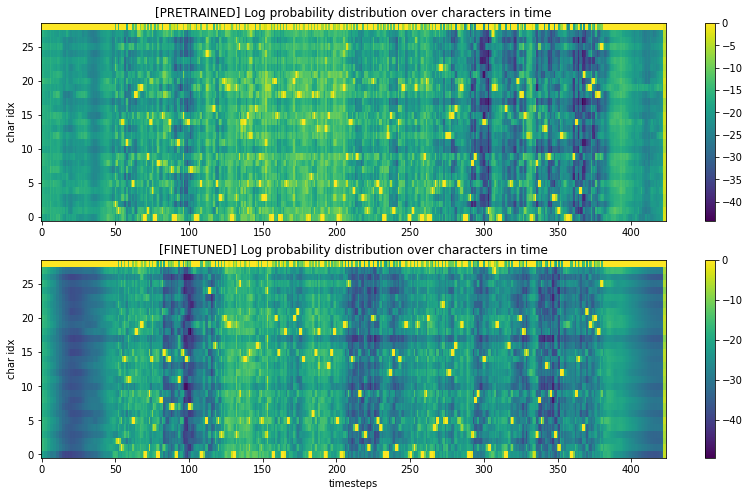

In [17]:
plt.figure(figsize=[14,8])
plt.subplot(211)
plt.imshow(probs.transpose())
plt.axis('tight')
plt.ylabel('char idx')
plt.colorbar()
plt.title('[PRETRAINED] Log probability distribution over characters in time')
plt.gca().invert_yaxis()

plt.subplot(212)
plt.imshow(f_probs.transpose())
plt.axis('tight')
plt.ylabel('char idx')
plt.xlabel('timesteps')
plt.colorbar()
plt.title('[FINETUNED] Log probability distribution over characters in time')
plt.gca().invert_yaxis()